In [167]:
import geopandas as gpd
import pandas as pd
from shapely import wkt
import json
import pandas as pd
import osmnx as ox
import matplotlib.pyplot as plt
import osmnx as ox
import networkx as nx
import GOSTnets as gn
import numpy as np
import datetime
import logging

import itertools
from multiprocessing import Pool, cpu_count


In [189]:
##Logger
logging.root.handlers.clear()
logging.root.handlers

timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
log_filename = f"logs/CuscoEdgesWaze1400_{timestamp}.log"

# logging.basicConfig(
#     level=logging.INFO,
#     datefmt='%Y-%m-%d %H:%M:%S',
# )

logger = logging.getLogger()
logger.setLevel(logging.INFO)

logFormatter = logging.Formatter('%(asctime)s :: %(levelname)s :: %(name)s :: %(process)d :: %(message)s')

# fileHandler = logging.FileHandler(log_filename)
# fileHandler.setFormatter(logFormatter)
# logger.addHandler(fileHandler)

streamHandler = logging.StreamHandler()
streamHandler.setFormatter(logFormatter)
logger.addHandler(streamHandler)
##Logger

In [190]:
logger.info("asdas")

2023-08-17 23:40:03,166 :: INFO :: root :: 26817 :: asdas


# Mapa Cusco

In [111]:
perushape = gpd.read_file("../../Turismo/shapes/peru.shp")
perushape.head()

,iddpto,departamen,idprov,provincia,iddist,distrito,capital,codccpp,area,fuente,geometry
0,01,AMAZONAS,0101,CHACHAPOYAS,010103,BALSAS,BALSAS,0001,1,INEI,"POLYGON ((-77.93289 -6.69210, -77.92945 -6.692..."
1,01,AMAZONAS,0105,LUYA,010515,PROVIDENCIA,PROVIDENCIA,0001,1,INEI,"POLYGON ((-78.29830 -6.27144, -78.29813 -6.271..."
2,01,AMAZONAS,0105,LUYA,010504,COLCAMAR,COLCAMAR,0001,1,INEI,"POLYGON ((-78.03590 -6.27044, -78.03246 -6.270..."
3,01,AMAZONAS,0106,RODRIGUEZ DE MENDOZA,010603,COCHAMAL,COCHAMAL,0001,1,INEI,"POLYGON ((-77.61592 -6.32152, -77.61650 -6.322..."
4,01,AMAZONAS,0105,LUYA,010514,PISUQUIA,YOMBLON,0001,1,INEI,"POLYGON ((-78.04105 -6.39687, -78.04115 -6.397..."


In [112]:
# cuscoshape = perushape[perushape['provincia'].isin(['CUSCO', 'QUISPICANCHI'])]
cuscoshape = perushape[perushape['provincia'].isin(['CUSCO'])]

cuscoshape.head()

,iddpto,departamen,idprov,provincia,iddist,distrito,capital,codccpp,area,fuente,geometry
722,08,CUSCO,0801,CUSCO,080106,SANTIAGO,SANTIAGO,0001,1,INEI,"POLYGON ((-71.98587 -13.52254, -71.98535 -13.5..."
723,08,CUSCO,0801,CUSCO,080108,WANCHAQ,WANCHAQ,0001,1,INEI,"POLYGON ((-71.94640 -13.52731, -71.94352 -13.5..."
761,08,CUSCO,0801,CUSCO,080102,CCORCA,CCORCA,0001,1,INEI,"POLYGON ((-72.06031 -13.52861, -72.05967 -13.5..."
764,08,CUSCO,0801,CUSCO,080105,SAN SEBASTIAN,SAN SEBASTIAN,0001,1,INEI,"POLYGON ((-71.91077 -13.47772, -71.90878 -13.4..."
767,08,CUSCO,0801,CUSCO,080107,SAYLLA,SAYLLA,0001,1,INEI,"POLYGON ((-71.81245 -13.50719, -71.81173 -13.5..."


In [99]:
!ls -l data

total 61564
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup  7834805 jul 31 23:23 EdgesCusco_wazeinfo.csv
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup  6769459 ago  8 21:43 GrafoCusco_edges.csv
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup  7839841 ago 12 10:45 GrafoCusco_edgeswaze0800.csv
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup  7835767 ago 13 10:07 GrafoCusco_edgeswaze1400.csv
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup  7834805 ago  8 21:45 GrafoCusco_edgeswaze.csv
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup   730523 ago  8 21:43 GrafoCusco_nodes.csv
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup  1086845 ago 17 22:19 GrafoCuscoTransporte_edges.csv
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup   168885 ago 17 22:19 GrafoCuscoTransporte_nodes.csv
-rw-r--r-- 1 leibnitz.rojas hadoopgroup  5459968 ago  9 22:44 GrafoCuscoWaze.gpkg
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup 11372052 ago  9 22:29 GrafoCuscoWaze.graphml
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup  1694626 may 24 21:53 RutasCusco.csv
-rw-rw-r-- 1 leibnitz.rojas hadoopgro

# Loading Nodes and Edges

In [101]:
nodes = pd.read_csv("data/GrafoCuscoTransporte0800_nodes.csv", index_col=[0])
nodes['geometry'] = nodes['geometry'].apply(wkt.loads)
nodes = gpd.GeoDataFrame(nodes, crs='epsg:4326')
# nodes

In [104]:
edges = pd.read_csv("data/GrafoCuscoTransporte0800_edges.csv", index_col=[0,1,2])
edges['geometry'] = edges['geometry'].apply(wkt.loads)
edges = gpd.GeoDataFrame(edges, crs='epsg:4326')

cond = edges['wazeinfo_km'] == -1
edges.loc[cond,'wazeinfo_minutes'] = np.nan
edges.loc[cond,'wazeinfo_km'] = np.nan
edges.loc[cond,'wazeinfo'] = np.nan

edges.head(3)

osmid               name      highway  \
u           v          key                                              
10232315911 30970895   0    316326176  Avenida Collasuyo    secondary   
            472615572  0    316326176  Avenida Collasuyo    secondary   
10803871753 5601181487 0    586164384                NaN  residential   

                           maxspeed  oneway   length  \
u           v          key                             
10232315911 30970895   0         40   False    9.202   
            472615572  0         40   False   85.249   
10803871753 5601181487 0        NaN   False  142.060   

                                                                     geometry  \
u           v          key                                                      
10232315911 30970895   0    LINESTRING (-71.95289 -13.52105, -71.95297 -13...   
            472615572  0    LINESTRING (-71.95289 -13.52105, -71.95233 -13...   
10803871753 5601181487 0    LINESTRING (-71.98694 -13.54986, -71.98684 -13...   

                           lanes  width  ref bridge access junction  \
u           v          key                                            
10232315911 30970895   0     NaN    NaN  NaN    NaN    NaN      NaN   
            472615572  0     NaN    NaN  NaN    NaN    NaN      NaN   
10803871753 5601181487 0     NaN    NaN  NaN    NaN    NaN      NaN   

                            wazeinfo_km  wazeinfo_minutes  wazeinfo  
u           v          key                                           
10232315911 30970895   0          0.008          0.016667       NaN  
            472615572  0          0.085          0.200000       NaN  
10803871753 5601181487 0          0.138          0.400000       NaN

In [107]:
# cond = edges['wazeinfo_km'] == -1
cond = edges['wazeinfo_km'].isna()
edges.loc[cond,:].shape

(10, 16)

In [150]:
G = ox.graph_from_gdfs(nodes, edges, )

In [110]:
amenities_gtransporte = pd.read_csv("data/AmenitiesGrafoTransporte.csv", index_col=[0])
amenities_gtransporte['geometry'] = amenities_gtransporte['geometry'].apply(wkt.loads)
amenities_gtransporte = gpd.GeoDataFrame(amenities_gtransporte, crs='epsg:4326')
amenities_gtransporte.head()

,unique_id,element_type,amenity,compressed_air,name,opening_hours,geometry_polygon,check_date,denomination,religion,...,contact:pinterest,contact:youtube,full_name,orientation,ways,type,isPoint,geometry,gtransporte_osmid,gtransporte_dist
osmid,,,,,,,,,,,,,,,,,,,,,
441195928,node/441195928,node,fuel,yes,PRIMAX,Mo-Su 00:00-12:00,POINT (-71.9124867 -13.5333168),NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,True,POINT (-71.91249 -13.53332),3241267614,0.000392
441195940,node/441195940,node,fuel,yes,REPSOL,Mo-Sa 00:00-12:00,POINT (-71.91688139999999 -13.5320491),NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,True,POINT (-71.91688 -13.53205),441195936,0.000138
444056852,node/444056852,node,toilets,NaN,NaN,NaN,POINT (-71.9893113 -13.5246483),NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,True,POINT (-71.98931 -13.52465),444056854,0.000770
444056860,node/444056860,node,toilets,NaN,NaN,NaN,POINT (-71.9868232 -13.5267277),NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,True,POINT (-71.98682 -13.52673),30985790,0.000541
444056873,node/444056873,node,place_of_worship,NaN,Iglesia de Nuestra Señora de Belén,NaN,POINT (-71.98132219999999 -13.5272097),2023-08-04,catholic,christian,...,NaN,NaN,NaN,NaN,NaN,NaN,True,POINT (-71.98132 -13.52721),30983330,0.000416


In [126]:
cond = amenities_gtransporte['amenity'] == 'bank'

nearestnodes2amenities = list(amenities_gtransporte.loc[cond,:]['gtransporte_osmid'].values)
nearestnodes2amenities = list(set(nearestnodes2amenities))
len(nearestnodes2amenities)

37

<AxesSubplot:>

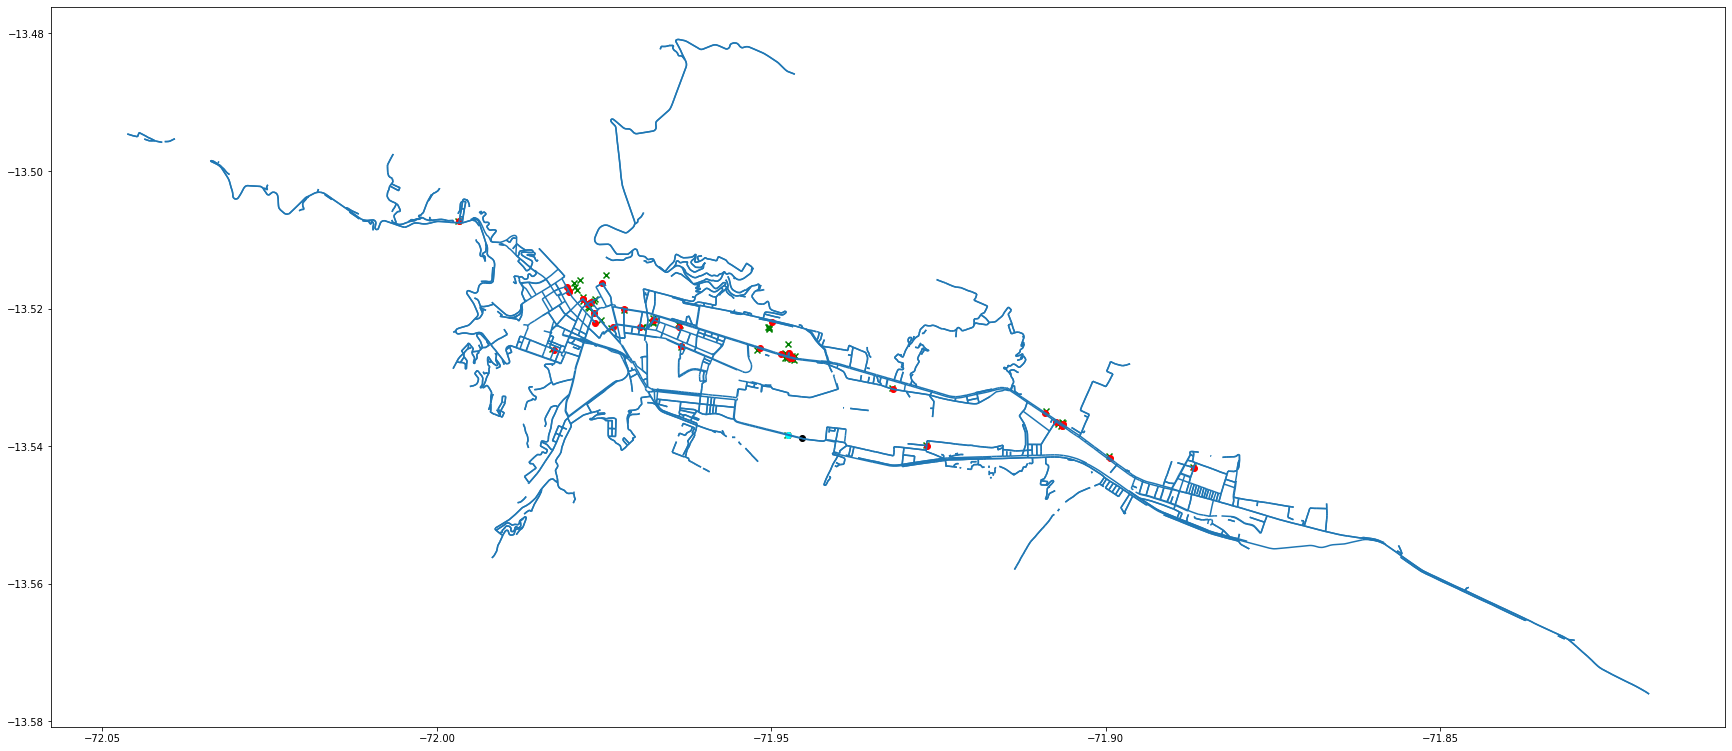

In [197]:
fig, ax = plt.subplots(figsize=(30,30))

# nodes.plot(ax=ax, color='g')
# edges.plot(ax=ax, color='yellow', alpha=0.5)
edges.plot(ax=ax)
# cuscoshape.plot(ax=ax, color='gray', alpha=0.2)
# rutascuscounique_gnodes.plot(ax=ax) 
# inputdf.plot(ax=ax, color='red')

# amenities_cols = ['unique_id', 'osmid', 'element_type', 'amenity', 'name',  'geometry',]
# amenities.loc[cond, amenities_cols ].head(2)
amenities_gtransporte.loc[cond, :].plot(ax=ax, color='green', marker='x' , )
# amenities_gtransporte.loc[[874430122], :].plot(ax=ax, color='black', )

nodes.loc[nearestnodes2amenities,:].plot(ax=ax, color='red')

# nodes.loc[nodes2plot,:].plot(ax=ax, color='red')
nodes.loc[[30962246],:].plot(ax=ax, color='black')
nodes.loc[[5600850986],:].plot(ax=ax, color='cyan')




In [129]:
nodes.head(3)

,y,x,street_count,highway,geometry
osmid,,,,,
4427153413,-13.552679,-71.876854,2,NaN,POINT (-71.87685 -13.55268)
10232315911,-13.521048,-71.952889,3,NaN,POINT (-71.95289 -13.52105)
10803871753,-13.549859,-71.986936,1,NaN,POINT (-71.98694 -13.54986)


2363

In [179]:
##nodes target
# nearestnodes2amenities

In [135]:
nodes_source = list(set(nodes.index))
print(len(nodes_source))
nodes_target = nearestnodes2amenities
print(len(nodes_target))

2363
37


In [137]:
nodes_sourcecrosstarget = list(itertools.product(nodes_source, nodes_target))

In [157]:
def shortest_path_transporte(G, node_source, node_target):
    try:
        res = nx.shortest_path_length(G, 
                                      source=node_source, 
                                      target=node_target, 
                                      weight='wazeinfo_minutes')
    except Exception as e:
        res = np.nan
    return res    

In [142]:
nodes_sourcecrosstarget_df = pd.DataFrame(nodes_sourcecrosstarget, columns=['source', 'target'])
nodes_sourcecrosstarget_df.head(3)

,source,target
0,4427153413,31003265
1,4427153413,31003267
2,4427153413,31003268


In [158]:
shortest_path_transporte(G, 4427153413, 31003267 )

nan

In [191]:
%%time
# nodes_sourcecrosstarget_df.head(20).apply(lambda x: shortest_path_transporte(G, x.source, x.target), axis=1 )

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 11 µs


In [162]:
nodes_sourcecrosstarget_df.shape[0]/40

2185.775

In [168]:
def process_row(row):
    result = shortest_path_transporte(G, row.source, row.target)
#     with open('CuscoEdgesWaze1400_Recupero03.txt', 'a') as f:
#         linea = f"{row.name};{row.u};{row.v};{result}\n"
#         f.write(linea)
    return result

def split_dataframe(df, chunk_size):
    chunks = [df[i:i + chunk_size] for i in range(0, df.shape[0], chunk_size)]
    return chunks

def apply_chunk(chunk):
    return chunk.apply(process_row, axis=1)

# Define the chunk size based on your dataset size and available resources
chunk_size = 5000

inputdf = nodes_sourcecrosstarget_df

data_chunks = split_dataframe(inputdf, chunk_size)

# Get the number of available CPU cores
# num_cores = cpu_count()
num_cores = int(inputdf.shape[0]/chunk_size)+1
if num_cores > cpu_count():
    num_cores = cpu_count()
print(f"Num Cores --> {num_cores}")

# # Create a multiprocessing pool with the number of cores
with Pool(num_cores) as pool:
    logger.info("Multiprocessing started.")
    results = pool.map(apply_chunk, data_chunks)
    logger.info("Multiprocessing completed.")

Num Cores --> 18


INFO:root:Multiprocessing started.
INFO:root:Multiprocessing completed.


In [174]:
results_df = pd.DataFrame(pd.concat(results), columns=['shortestpath_minutes'])
results_df

,shortestpath_minutes
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
87426,2.533333
87427,5.383333
87428,7.050000
87429,4.833333


In [176]:
tmp = nodes_sourcecrosstarget_df.merge(results_df, how='left', left_index=True, right_index=True)
tmp

,source,target,shortestpath_minutes
0,4427153413,31003265,NaN
1,4427153413,31003267,NaN
2,4427153413,31003268,NaN
3,4427153413,30983683,NaN
4,4427153413,30983434,NaN
...,...,...,...
87426,30965748,30985592,2.533333
87427,30965748,30964345,5.383333
87428,30965748,31003258,7.050000
87429,30965748,30964987,4.833333


In [200]:
tmp.pivot(index='source', columns='target', values='shortestpath_minutes')

target,30963663,30963982,30964345,30964382,30964385,30964987,30983434,30983435,30983668,30983679,...,2668103368,2710884270,3089639244,3248394097,3738278158,3738278161,3739415858,3778595776,5310407103,5600850986
source,,,,,,,,,,,,,,,,,,,,,
30962246,5.600000,5.600000,6.583333,6.683333,6.850000,6.033333,7.750000,7.750000,7.483333,7.266667,...,NaN,8.583333,8.466667,7.366667,7.766667,7.633333,5.600000,8.800000,8.283333,0.033333
30962247,5.600000,5.600000,6.550000,6.650000,6.816667,6.000000,7.716667,7.716667,7.450000,7.233333,...,NaN,8.550000,8.466667,7.333333,7.733333,7.600000,5.600000,8.766667,8.250000,0.000000
30962248,6.000000,6.000000,6.550000,6.650000,6.816667,6.000000,7.716667,7.716667,7.450000,7.233333,...,NaN,8.550000,8.866667,7.333333,7.733333,7.600000,6.000000,8.766667,8.250000,0.000000
30962249,6.000000,6.000000,6.550000,6.650000,6.816667,6.000000,7.716667,7.716667,7.450000,7.233333,...,NaN,8.550000,8.866667,7.333333,7.733333,7.600000,6.000000,8.766667,8.250000,0.000000
30962250,6.500000,6.500000,6.550000,6.650000,6.816667,6.000000,7.716667,7.716667,7.450000,7.233333,...,NaN,8.550000,9.366667,7.333333,7.733333,7.600000,6.500000,8.766667,8.250000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10866439655,3.750000,3.750000,11.250000,10.966667,10.850000,11.400000,12.883333,12.883333,13.916667,13.700000,...,NaN,8.100000,6.916667,11.416667,12.583333,13.233333,3.750000,7.783333,12.333333,13.316667
10885685965,4.733333,4.733333,10.983333,10.700000,10.583333,11.133333,12.616667,12.616667,13.650000,13.433333,...,NaN,7.833333,6.650000,11.150000,12.316667,12.966667,4.733333,7.516667,12.066667,13.816667
10928544719,10.816667,10.816667,4.866667,4.583333,4.466667,5.233333,6.500000,6.500000,7.533333,7.316667,...,NaN,6.433333,9.350000,5.033333,6.200000,6.850000,10.816667,5.916667,5.950000,8.083333
